# Lab 4

## Getting Data and HD5

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20, 15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()

<KeysViewHDF5 ['data']>

In [3]:
data = np.array(hf.get('data'))
data[:, 0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [4]:
hf.close()

## Problem 1

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

As with most data, there are 'features.' Your lab instructor has helpfully incorporated the meta-data into your data file.

1) Down load the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

In [5]:
time = data[0, :]
solar_phase = data[1, :]
longitude = data[2, :]
particle_count = data[3, :]

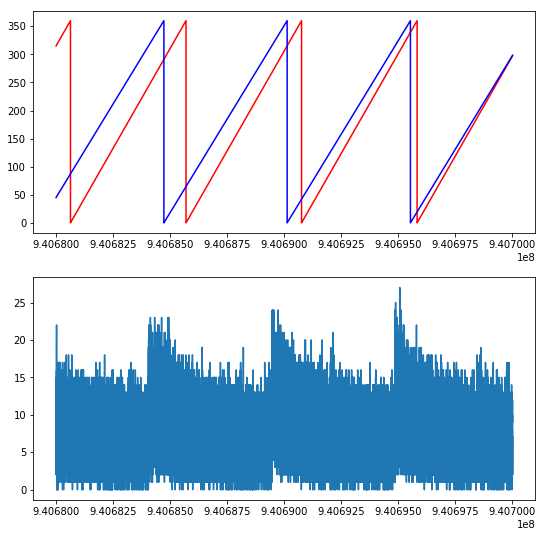

In [39]:
#Lets plot some pieces of the data set early and later.
count=200000
early = time[0:count]
early_solar = solar_phase[0:count]
early_longitude = longitude[0:count]
early_particles = particle_count[0:count]

figure = plt.figure(figsize=(9, 9))
axes = figure.subplots(2, 1)

# These are cycling through 0 to 360 degrees
axes[0].plot(early, early_solar, 'r');
axes[0].plot(early, early_longitude, 'b');

# This one has a weird jump right around 40k time steps or so
axes[1].step(early, early_particles, where='mid');

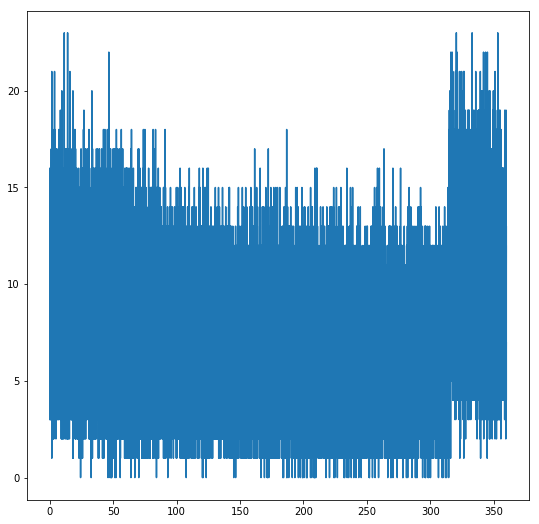

In [38]:
figure = plt.figure(figsize=(9,9))
ax = figure.subplots()

count = 60000
x = longitude[0:count]
particles = particle_count[0:count]
ax.plot(x, particles);

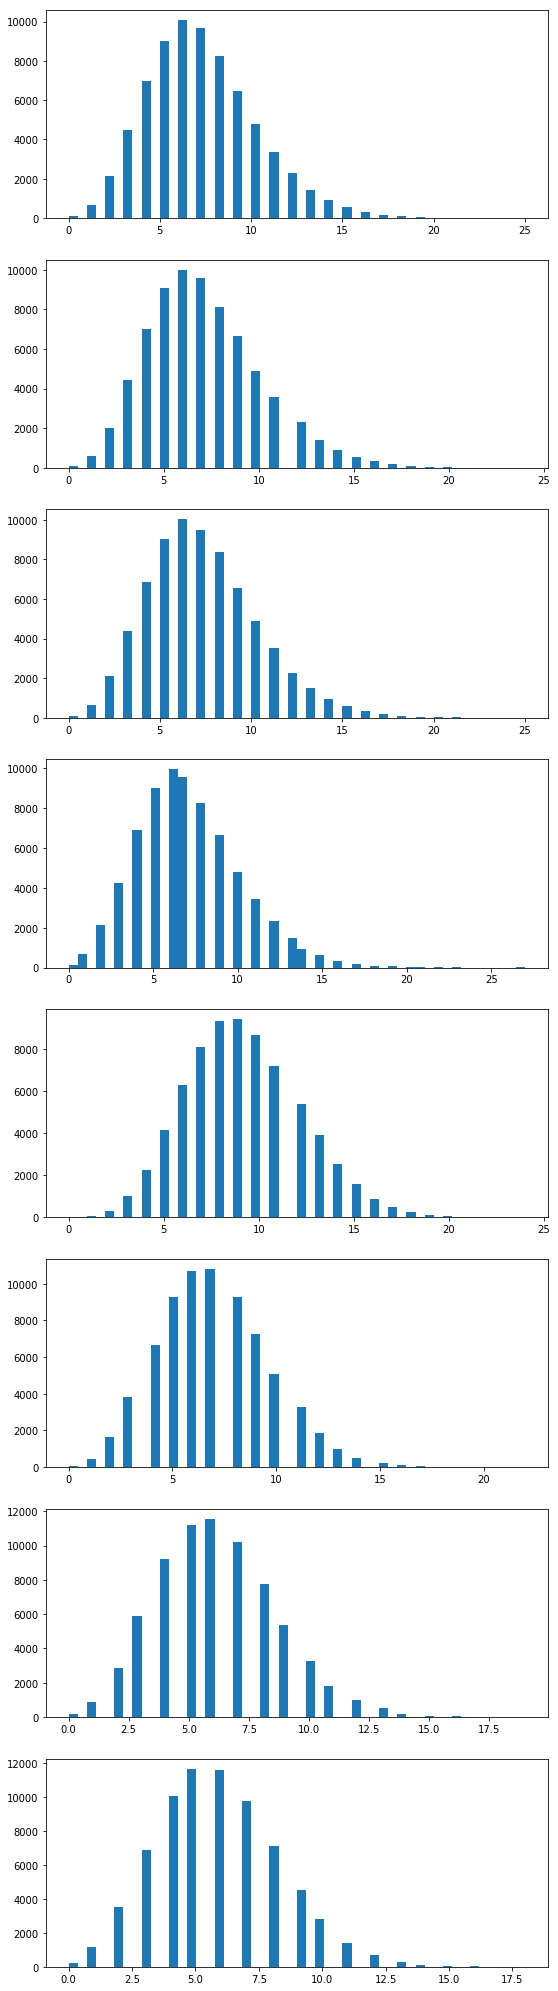

In [40]:
plots = 8
figure = plt.figure(figsize=(9, 4.5*plots))
axes = figure.subplots(plots, 1)

solar_particles = particle_count[np.floor(solar_phase) == 0]
axes[0].hist(solar_particles, bins=50);
solar_particles = particle_count[np.floor(solar_phase) == 90]
axes[1].hist(solar_particles, bins=50);
solar_particles = particle_count[np.floor(solar_phase) == 180]
axes[2].hist(solar_particles, bins=50);
solar_particles = particle_count[np.floor(solar_phase) == 270]
axes[3].hist(solar_particles, bins=50);

longitude_particles = particle_count[np.floor(longitude) == 0]
axes[4].hist(longitude_particles, bins=50);
longitude_particles = particle_count[np.floor(longitude) == 90]
axes[5].hist(longitude_particles, bins=50);
longitude_particles = particle_count[np.floor(longitude) == 180]
axes[6].hist(longitude_particles, bins=50);
longitude_particles = particle_count[np.floor(longitude) == 270]
axes[7].hist(longitude_particles, bins=50);

2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

One way it is inconsistent is looking at the particle count versus time graph. We see a suspicious jump in particle counts that decays back down to a lower value. Looking at a graph of the longitude versus the counts, it is made clear that there is a jump in counts right around -50 degrees longitude to +30 degrees longitude. This is consistent with the South Atlantic Anomaly, which is over that patch and is where more energetic particles are able to get close to Earth's surface.

3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

Since we are counting particles in most of these models, we are going to use a Poisson. It is dependent on the longitude what the mean will be, and the longitude is dependent on the time in the satellites orbit.

In [41]:
# pdf here


4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

## Problem 2

In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

1) Dowload the data from `images.h5`. This is a stack of 10 square images, each 200 pixels on a side.

2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.